In [1]:
# simulate_predictors.py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque, defaultdict
import os
import time # Import time for basic profiling

# --- Basic Predictor Implementations (Keep 1-Bit, 2-Bit, 2-Level, Tournament) ---
class OneBitPredictor:
    def __init__(self):
        self.states = defaultdict(lambda: 0)
    def predict(self, pc): return self.states[pc]
    def update(self, pc, actual_outcome):
        if self.predict(pc) != actual_outcome: self.states[pc] = 1 - self.states[pc]

class TwoBitPredictor:
    def __init__(self):
        self.counters = defaultdict(lambda: 0)
    def predict(self, pc): return 1 if self.counters[pc] >= 2 else 0
    def update(self, pc, actual_outcome):
        state = self.counters[pc]
        if actual_outcome == 1: self.counters[pc] = min(state + 1, 3)
        else: self.counters[pc] = max(state - 1, 0)

class TwoLevelPredictor:
    def __init__(self, ghr_bits=4, pht_size=16):
        self.ghr_bits = ghr_bits
        self.ghr = deque([0] * ghr_bits, maxlen=ghr_bits)
        self.pht = defaultdict(lambda: 0)
        self.pht_size = pht_size
    def _get_pht_index(self, pc):
        ghr_val = 0
        for bit in self.ghr: ghr_val = (ghr_val << 1) | bit
        pc_masked = pc & (self.pht_size - 1)
        return pc_masked ^ ghr_val
    def predict(self, pc): return 1 if self.pht[self._get_pht_index(pc)] >= 2 else 0
    def update(self, pc, actual_outcome):
        index = self._get_pht_index(pc)
        state = self.pht[index]
        if actual_outcome == 1: self.pht[index] = min(state + 1, 3)
        else: self.pht[index] = max(state - 1, 0)
        self.ghr.appendleft(actual_outcome)

class TournamentPredictor:
    def __init__(self, ghr_bits=4, pht_size=16, num_selectors=16):
        self.local_predictor = TwoBitPredictor()
        self.global_predictor = TwoLevelPredictor(ghr_bits, pht_size)
        self.selectors = defaultdict(lambda: 0)
        self.num_selectors = num_selectors
    def _get_selector_index(self, pc): return pc & (self.num_selectors - 1)
    def predict(self, pc):
        selector_state = self.selectors[self._get_selector_index(pc)]
        return self.global_predictor.predict(pc) if selector_state >= 2 else self.local_predictor.predict(pc)
    def update(self, pc, actual_outcome):
        local_pred = self.local_predictor.predict(pc)
        global_pred = self.global_predictor.predict(pc)
        self.local_predictor.update(pc, actual_outcome)
        self.global_predictor.update(pc, actual_outcome)
        local_correct = (local_pred == actual_outcome)
        global_correct = (global_pred == actual_outcome)
        selector_index = self._get_selector_index(pc)
        selector_state = self.selectors[selector_index]
        if local_correct and not global_correct: self.selectors[selector_index] = max(selector_state - 1, 0)
        elif not local_correct and global_correct: self.selectors[selector_index] = min(selector_state + 1, 3)

# --- Simplified BranchNet Implementations (Keep CNN, LSTM, Transformer build functions) ---

def build_simple_branchnet_cnn(history_window_size, num_features=1):
    
    model = keras.Sequential(
        [
            keras.Input(shape=(history_window_size, num_features)),
            layers.Conv1D(filters=32, kernel_size=5, padding='causal', activation="relu"),
            layers.BatchNormalization(),
            layers.Conv1D(filters=64, kernel_size=5, padding='causal', activation="relu"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(pool_size=2), # Added Pooling
            layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation="relu"), # Added Layer
            layers.GlobalAveragePooling1D(),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

def build_simple_branchnet_lstm(history_window_size, num_features=1):
    
    model = keras.Sequential(
        [
            keras.Input(shape=(history_window_size, num_features)),
            layers.Conv1D(filters=32, kernel_size=5, padding='causal', activation="relu"),
            layers.BatchNormalization(),
            layers.Conv1D(filters=64, kernel_size=5, padding='causal', activation="relu"),
            layers.BatchNormalization(),
            layers.LSTM(32, return_sequences=False),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

def build_simple_branchnet_transformer(history_window_size, num_features=1, head_size=64, num_heads=4, ff_dim=32, num_transformer_blocks=1):
    # ... (keep function definition as before) ...
    inputs = keras.Input(shape=(history_window_size, num_features))
    x = inputs
    for _ in range(num_transformer_blocks):
        attention_output = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=0.1)(x, x)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        ffn_output = layers.Dense(ff_dim, activation="relu")(x)
        ffn_output = layers.Dense(num_features)(ffn_output)
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

# --- Simulation Function (Simplified - NO FUSION) ---

def simulate_predictors_no_fusion(full_history, basic_predictors, ml_models, history_window_size=16):
    """Simulates predictors and returns their accuracy. No Fusion."""
    # Initialize results dictionaries
    results = {name: {'correct': 0, 'total': 0} for name in basic_predictors}
    results.update({name: {'correct': 0, 'total': 0} for name in ml_models})

    branch_pc = 0xABC # Fixed PC

    history_buffer = deque([0] * history_window_size, maxlen=history_window_size) # For ML models

    # --- Performance Profiling Variables ---
    ml_predict_time = 0
    basic_predict_time = 0
    loop_start_time = time.time()
    # --------------------------------------

    for i in range(len(full_history)):
        actual_outcome = full_history[i]
        can_predict_ml_this_step = (i >= history_window_size)

        # Predicting with Standalone Basic Predictors
        t_start = time.perf_counter()
        basic_preds_this_step = {}
        for name, predictor in basic_predictors.items():
            basic_preds_this_step[name] = predictor.predict(branch_pc) # Store prediction
            if basic_preds_this_step[name] == actual_outcome:
                results[name]['correct'] += 1
            results[name]['total'] += 1
        basic_predict_time += (time.perf_counter() - t_start)


        # Predicting with Standalone ML Models
        t_start = time.perf_counter()
        if can_predict_ml_this_step:
            current_window = np.array(history_buffer).reshape(1, history_window_size, 1)
            for name, model in ml_models.items():
                # Predict probability
                prob_taken = model.predict(current_window, verbose=0)[0][0]
                # Threshold probability
                ml_pred = 1 if prob_taken >= 0.5 else 0
                if ml_pred == actual_outcome: results[name]['correct'] += 1
                results[name]['total'] += 1 # Total increments only after warm-up
        ml_predict_time += (time.perf_counter() - t_start)


        # UPDATE Phase (Only Basic Predictors Need State Update)
        for name, predictor in basic_predictors.items():
            predictor.update(branch_pc, actual_outcome)


        # Update History Buffer for NEXT iteration's ML predictions
        history_buffer.append(actual_outcome)

        # Progress Indicator
        if (i + 1) % 100 == 0: # Print progress every 100 steps
             print(f"\rSimulating step {i+1}/{len(full_history)}...", end="")


    # --- End of Loop ---
    loop_end_time = time.time()
    print(f"\nSimulation loop finished in {loop_end_time - loop_start_time:.2f} seconds.")
    print(f"Time spent in basic predictions: {basic_predict_time:.4f} s")
    print(f"Time spent in ML predictions: {ml_predict_time:.4f} s")
    # --------------------

    # Calculate final accuracies
    accuracies = {}
    for name, res in results.items():
        if res['total'] > 0: accuracies[name] = res['correct'] / res['total']
        else: accuracies[name] = 0.0

    return accuracies

# --- Main Execution ---

if __name__ == "__main__":
    HISTORY_WINDOW_SIZE = 16
    DATA_FILE = 'branchnet_training_data.npz'

    # 1. Load Data
    # ... (keep load data section as before) ...
    print(f"Loading data from {DATA_FILE}...")
    data = np.load(DATA_FILE)
    X_train_full = data['X']
    y_train_full = data['y']
    full_history = data['full_history']
    print(f"Loaded full history length: {len(full_history)}")

    split_idx = int(len(X_train_full) * 0.8)
    X_val, y_val = X_train_full[split_idx:], y_train_full[split_idx:]
    X_train, y_train = X_train_full[:split_idx], y_train_full[:split_idx]


    # 2. Build and Train ML Models
    ml_models = {}
    epochs_to_train = 15 # Adjust as needed

    print("\n--- Building and Training ML Models ---")
    # --- CNN ---
    print("\nTraining Simple_BranchNet_CNN...")
    ml_models['BranchNet_CNN'] = build_simple_branchnet_cnn(HISTORY_WINDOW_SIZE)
    ml_models['BranchNet_CNN'].fit(X_train, y_train, epochs=epochs_to_train, batch_size=32, validation_data=(X_val, y_val), verbose=0) # Set verbose=0 to reduce training output
    print("CNN Training Complete.")

    # --- CNN+LSTM ---
    print("\nTraining Simple_BranchNet_LSTM...")
    ml_models['BranchNet_LSTM'] = build_simple_branchnet_lstm(HISTORY_WINDOW_SIZE)
    ml_models['BranchNet_LSTM'].fit(X_train, y_train, epochs=epochs_to_train, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    print("LSTM Training Complete.")

    # --- Transformer ---
    print("\nTraining Simple_BranchNet_Transformer...")
    ml_models['BranchNet_Transformer'] = build_simple_branchnet_transformer(HISTORY_WINDOW_SIZE)
    ml_models['BranchNet_Transformer'].fit(X_train, y_train, epochs=epochs_to_train, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    print("Transformer Training Complete.")


    # 3. Initialize Basic Predictors
    # These are the only ones simulated now, besides the ML models
    basic_predictors_standalone = {
        "1-Bit": OneBitPredictor(),
        "2-Bit": TwoBitPredictor(),
        "2-Level": TwoLevelPredictor(ghr_bits=4),
        "Tournament": TournamentPredictor(ghr_bits=4)
    }


    # 4. Run Simulation (Call the NO FUSION version)
    print("\nSimulating all predictors (NO FUSION)...")
    start_sim_time = time.time()
    accuracies = simulate_predictors_no_fusion( # Call the modified function
        full_history,
        basic_predictors_standalone,
        ml_models,
        history_window_size=HISTORY_WINDOW_SIZE
    )
    end_sim_time = time.time()
    print(f"\nTotal simulation function time: {end_sim_time - start_sim_time:.2f} seconds")


    # 5. Print Results
    print("\n--- Simulation Results ---")
    # Print basic predictors first
    for name in ["1-Bit", "2-Bit", "2-Level", "Tournament"]:
         print(f"{name:>20}: {accuracies.get(name, 0.0):.4f} Accuracy")
    # Print ML models
    for name in sorted(ml_models.keys()):
        print(f"{name:>20}: {accuracies.get(name, 0.0):.4f} Accuracy")

Loading data from branchnet_training_data.npz...
Loaded full history length: 1000

--- Building and Training ML Models ---

Training Simple_BranchNet_CNN...
CNN Training Complete.

Training Simple_BranchNet_LSTM...
LSTM Training Complete.

Training Simple_BranchNet_Transformer...
Transformer Training Complete.

Simulating all predictors (NO FUSION)...
Simulating step 1000/1000...
Simulation loop finished in 443.34 seconds.
Time spent in basic predictions: 0.0276 s
Time spent in ML predictions: 443.2279 s

Total simulation function time: 443.34 seconds

--- Simulation Results ---
               1-Bit: 0.4840 Accuracy
               2-Bit: 0.4290 Accuracy
             2-Level: 0.6480 Accuracy
          Tournament: 0.5900 Accuracy
       BranchNet_CNN: 0.8283 Accuracy
      BranchNet_LSTM: 0.9146 Accuracy
BranchNet_Transformer: 0.5437 Accuracy


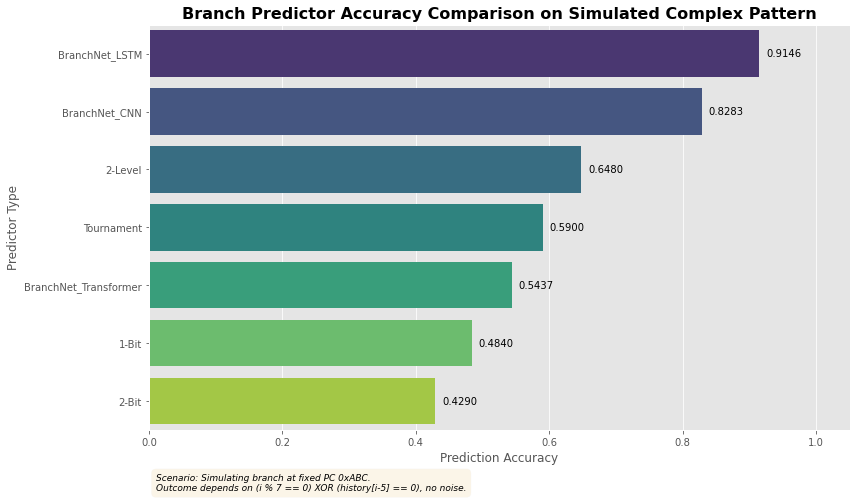

Visualization saved as predictor_accuracy_comparison.png


In [5]:
# visualization.py (or run this in a Jupyter cell)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Results Data (from your output) ---
results_data = {
    "1-Bit": 0.4840,
    "2-Bit": 0.4290,
    "2-Level": 0.6480,
    "Tournament": 0.5900,
    "BranchNet_CNN": 0.8283,
    "BranchNet_LSTM": 0.9146,
    "BranchNet_Transformer": 0.5437
}

# --- Prepare Data for Plotting ---
predictors = list(results_data.keys())
accuracies = list(results_data.values())

# Create a Pandas DataFrame for easier plotting with Seaborn
df = pd.DataFrame({'Predictor': predictors, 'Accuracy': accuracies})

# Sort by accuracy for better visualization
df = df.sort_values(by='Accuracy', ascending=False)

# --- Create Visualization ---

plt.style.use('ggplot') # Use a clean Seaborn style

plt.figure(figsize=(12, 7)) # Adjust figure size for better readability

# Create the bar plot
barplot = sns.barplot(x='Accuracy', y='Predictor', data=df, palette='viridis', orient='h')

# Add accuracy values on the bars
for index, value in enumerate(df['Accuracy']):
    plt.text(value + 0.01, # Position text slightly to the right of the bar
             index, # Y-position aligned with the bar center
             f'{value:.4f}', # Format accuracy to 4 decimal places
             va='center', # Vertical alignment
             fontsize=10,
             color='black')

# Add titles and labels
plt.title('Branch Predictor Accuracy Comparison on Simulated Complex Pattern', fontsize=16, fontweight='bold')
plt.xlabel('Prediction Accuracy', fontsize=12)
plt.ylabel('Predictor Type', fontsize=12)
plt.xlim(0, 1.05) # Set x-axis limits (slightly > 1 for text placement)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a descriptive annotation about the scenario
scenario_text = ("Scenario: Simulating branch at fixed PC 0xABC.\n"
                 "Outcome depends on (i % 7 == 0) XOR (history[i-5] == 0), no noise.")
plt.text(0.01, -0.15, scenario_text, transform=plt.gca().transAxes, # Position relative to axes
         fontsize=9, style='italic', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.3))


plt.tight_layout() # Adjust layout to prevent labels overlapping

# Save the figure
plt.savefig('predictor_accuracy_comparison.png', dpi=300)

# Show the plot (if running in an environment that supports it, like Jupyter)
plt.show()

print("Visualization saved as predictor_accuracy_comparison.png")

In [6]:
# consolidated_visualizations.py

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# --- Results Data (from your output) ---
results_data = {
    "1-Bit": 0.4840,
    "2-Bit": 0.4290,
    "2-Level": 0.6480,
    "Tournament": 0.5900,
    "BranchNet_CNN": 0.8283,
    "BranchNet_LSTM": 0.9146,
    "BranchNet_Transformer": 0.5437
}

# --- Style ---
plt.style.use('ggplot') # Use ggplot style for all plots

# --- Prepare DataFrames ---
predictors = list(results_data.keys())
accuracies = list(results_data.values())

# DataFrame for standard bar/lollipop
df_std = pd.DataFrame({'Predictor': predictors, 'Accuracy': accuracies})

# DataFrame for grouped bar chart
categories = []
for p in predictors:
    if 'BranchNet' in p: categories.append('ML-Based') # Simplified label
    else: categories.append('Traditional')
df_grouped = pd.DataFrame({'Predictor': predictors, 'Accuracy': accuracies, 'Category': categories})
df_grouped = df_grouped.sort_values(by=['Category', 'Accuracy'], ascending=[True, False])

# DataFrame for radar
df_radar_prep = pd.DataFrame([results_data])


# --- Plot 1: Horizontal Bar Chart ---
print("Generating Bar Chart...")
df_sorted_bar = df_std.sort_values(by='Accuracy', ascending=False)
plt.figure(figsize=(12, 7))
barplot = sns.barplot(x='Accuracy', y='Predictor', data=df_sorted_bar, palette='viridis', orient='h')
for index, value in enumerate(df_sorted_bar['Accuracy']):
    plt.text(value + 0.01, index, f'{value:.4f}', va='center', fontsize=9, color='black')
plt.title('Predictor Accuracy Comparison (Bar Chart)', fontsize=16, fontweight='bold')
plt.xlabel('Prediction Accuracy', fontsize=12)
plt.ylabel('Predictor Type', fontsize=12)
plt.xlim(0, 1.05)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# Scenario text (optional, customize as needed)
scenario_text = "Scenario: XOR(i%7==0, history[i-5]==0), no noise. PC=0xABC"
plt.text(0.01, -0.12, scenario_text, transform=plt.gca().transAxes, fontsize=9, style='italic',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.3))
plt.tight_layout()
plt.savefig('predictor_accuracy_comparison.png', dpi=300)
plt.close() # Close the figure to free memory before the next plot


# --- Plot 2: Lollipop Chart ---
print("Generating Lollipop Chart...")
df_sorted_lollipop = df_std.sort_values(by='Accuracy', ascending=True)
plt.figure(figsize=(8, 10))
plt.vlines(x=df_sorted_lollipop['Predictor'], ymin=0, ymax=df_sorted_lollipop['Accuracy'], color='skyblue', alpha=0.7, linewidth=1)
plt.scatter(x=df_sorted_lollipop['Predictor'], y=df_sorted_lollipop['Accuracy'], color='dodgerblue', s=75, alpha=1)
for i, row in df_sorted_lollipop.iterrows():
    plt.text(row['Predictor'], row['Accuracy'] + 0.02, f'{row["Accuracy"]:.4f}', ha='center', va='bottom', fontsize=9)
plt.title('Predictor Accuracy Comparison (Lollipop)', fontsize=16, fontweight='bold')
plt.ylabel('Prediction Accuracy', fontsize=12)
plt.xlabel('Predictor Type', fontsize=12)
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('predictor_accuracy_lollipop.png', dpi=300)
plt.close()


# --- Plot 3: Grouped Bar Chart ---
print("Generating Grouped Bar Chart...")
plt.figure(figsize=(10, 6))
# Use the pre-sorted grouped DataFrame
barplot_grouped = sns.barplot(x='Accuracy', y='Predictor', hue='Category', data=df_grouped,
                              palette={'Traditional': 'coral', 'ML-Based': 'mediumseagreen'}, # Different palette
                              dodge=False, orient='h')
plt.title('Predictor Accuracy: Traditional vs. ML-Based', fontsize=16, fontweight='bold')
plt.xlabel('Prediction Accuracy', fontsize=12)
plt.ylabel('Predictor Type', fontsize=12)
plt.xlim(0, 1.05)
plt.legend(title='Predictor Category', title_fontsize='11', fontsize='10', loc='lower right')
plt.tight_layout()
plt.savefig('predictor_accuracy_grouped.png', dpi=300)
plt.close()


# --- Plot 4: Radar Chart ---
print("Generating Radar Chart...")
labels_radar = df_radar_prep.columns
num_vars_radar = len(labels_radar)
angles_radar = np.linspace(0, 2 * np.pi, num_vars_radar, endpoint=False).tolist()
angles_radar += angles_radar[:1]
values_radar = df_radar_prep.iloc[0].values.flatten().tolist()
values_radar += values_radar[:1]

fig_radar, ax_radar = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax_radar.plot(angles_radar, values_radar, linewidth=1, linestyle='solid', label='Accuracy', color='mediumpurple') # Different color
ax_radar.fill(angles_radar, values_radar, 'mediumpurple', alpha=0.4)
ax_radar.set_yticks(np.arange(0, 1.1, 0.2))
ax_radar.set_ylim(0, 1.05)
ax_radar.set_xticks(angles_radar[:-1])
ax_radar.set_xticklabels(labels_radar)
plt.title('Branch Predictor Accuracy Comparison (Radar)', size=16, y=1.1)
plt.tight_layout()
plt.savefig('predictor_accuracy_radar.png', dpi=300)
plt.close() # Close the last figure


print("\nAll visualizations generated:")
print("- predictor_accuracy_comparison.png (Bar)")
print("- predictor_accuracy_lollipop.png (Lollipop)")
print("- predictor_accuracy_grouped.png (Grouped Bar)")
print("- predictor_accuracy_radar.png (Radar)")

Generating Bar Chart...
Generating Lollipop Chart...
Generating Grouped Bar Chart...
Generating Radar Chart...

All visualizations generated:
- predictor_accuracy_comparison.png (Bar)
- predictor_accuracy_lollipop.png (Lollipop)
- predictor_accuracy_grouped.png (Grouped Bar)
- predictor_accuracy_radar.png (Radar)


In [7]:
plt.show()